In [69]:
import scipy.stats as stats
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler


from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, make_scorer,
                             confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier
from xgboost import XGBRegressor, XGBClassifier
import xgboost

%matplotlib inline
from sklearn.datasets import load_boston

from sklearn.base import clone
from sklearn import tree


In [49]:
df = pd.read_csv('data/data.csv')

In [50]:
df.head(3)

,ClaColada,cla_secuencia,NumBarraAceWT,Permanencia,tco_tcm,cla_grado_obtenido,cla_grupo_chatarra,rollo,CH01,CH02,...,CH68,CH69,CH70,CH71,CH72,CH73,CH74,CH75,cla_defecto,tieneDefecto
0,195250,187034,1845821,5468,130.300003,2437,11,1,12200,33000,...,0,0,0,4100,0,0,0,0,0,0
1,195377,185965,1831592,9167,130.199997,28,11,1,13300,13800,...,0,0,0,4400,0,0,0,0,0,0
2,195377,185966,1831593,9163,130.199997,28,11,1,13300,13800,...,0,0,0,4400,0,0,0,0,0,0


In [51]:
df = df[df['tco_tcm'] < 135 ]
df = df[df['tco_tcm'] > 110 ]
df.drop("rollo", axis=1, inplace=True)
df.drop("cla_defecto", axis=1, inplace=True)

In [52]:
#eliminamos las columnas donde la suma es 0, ya que hay chatarras que jamnás se usan
# de 55 columnas, pasamos a 26
l = list(df.columns.values)
for l in l:
    if sum(df[l]) == 0:
        df.drop(l, axis=1, inplace=True)        
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15357
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ClaColada           15284 non-null  int64  
 1   cla_secuencia       15284 non-null  int64  
 2   NumBarraAceWT       15284 non-null  int64  
 3   Permanencia         15284 non-null  int64  
 4   tco_tcm             15284 non-null  float64
 5   cla_grado_obtenido  15284 non-null  int64  
 6   cla_grupo_chatarra  15284 non-null  int64  
 7   CH01                15284 non-null  int64  
 8   CH02                15284 non-null  int64  
 9   CH03                15284 non-null  int64  
 10  CH04                15284 non-null  int64  
 11  CH06                15284 non-null  int64  
 12  CH07                15284 non-null  int64  
 13  CH08                15284 non-null  int64  
 14  CH09                15284 non-null  int64  
 15  CH10                15284 non-null  int64  
 16  CH31

In [53]:
#comprobamos que el dataset no contiene nulos
df.isna().sum()

ClaColada             0
cla_secuencia         0
NumBarraAceWT         0
Permanencia           0
tco_tcm               0
cla_grado_obtenido    0
cla_grupo_chatarra    0
CH01                  0
CH02                  0
CH03                  0
CH04                  0
CH06                  0
CH07                  0
CH08                  0
CH09                  0
CH10                  0
CH31                  0
CH33                  0
CH34                  0
CH50                  0
CH60                  0
CH63                  0
CH71                  0
tieneDefecto          0
dtype: int64

In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ClaColada,15284.0,1.986719e+05,627.929010,1.952500e+05,1.982730e+05,1.988990e+05,1.991420e+05,1.993520e+05
cla_secuencia,15284.0,1.898401e+05,1188.748161,1.855330e+05,1.889220e+05,1.902940e+05,1.908650e+05,1.911750e+05
NumBarraAceWT,15284.0,1.886063e+06,16856.642309,1.825670e+06,1.872949e+06,1.892584e+06,1.900247e+06,1.904958e+06
Permanencia,15284.0,8.101790e+03,3352.985063,4.391000e+03,5.907750e+03,6.838000e+03,9.008000e+03,1.025680e+05
tco_tcm,15284.0,1.286542e+02,2.171476,1.202000e+02,1.276000e+02,1.286000e+02,1.304000e+02,1.346000e+02
cla_grado_obtenido,15284.0,1.769313e+03,901.785855,2.100000e+01,1.039000e+03,2.019000e+03,2.427000e+03,2.464000e+03
cla_grupo_chatarra,15284.0,5.730306e+00,2.715673,2.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,1.100000e+01
CH01,15284.0,1.005180e+04,1069.406778,0.000000e+00,9.900000e+03,1.030000e+04,1.060000e+04,1.330000e+04
CH02,15284.0,3.219221e+04,9548.967672,0.000000e+00,2.500000e+04,3.160000e+04,3.580000e+04,8.800000e+04
CH03,15284.0,2.424814e+04,8106.512517,6.100000e+03,1.900000e+04,2.490000e+04,2.960000e+04,4.100000e+04


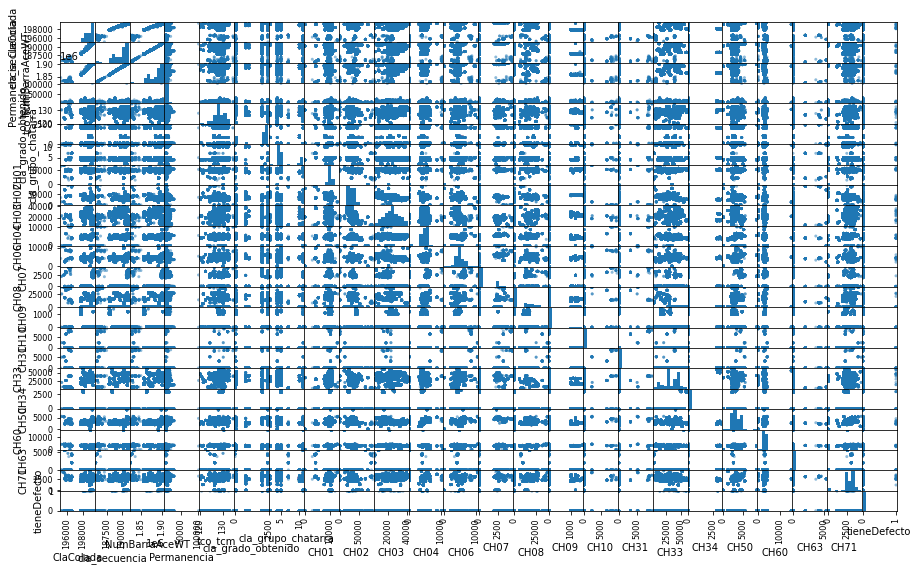

In [55]:
scatter_matrix(df, figsize=(15,9));

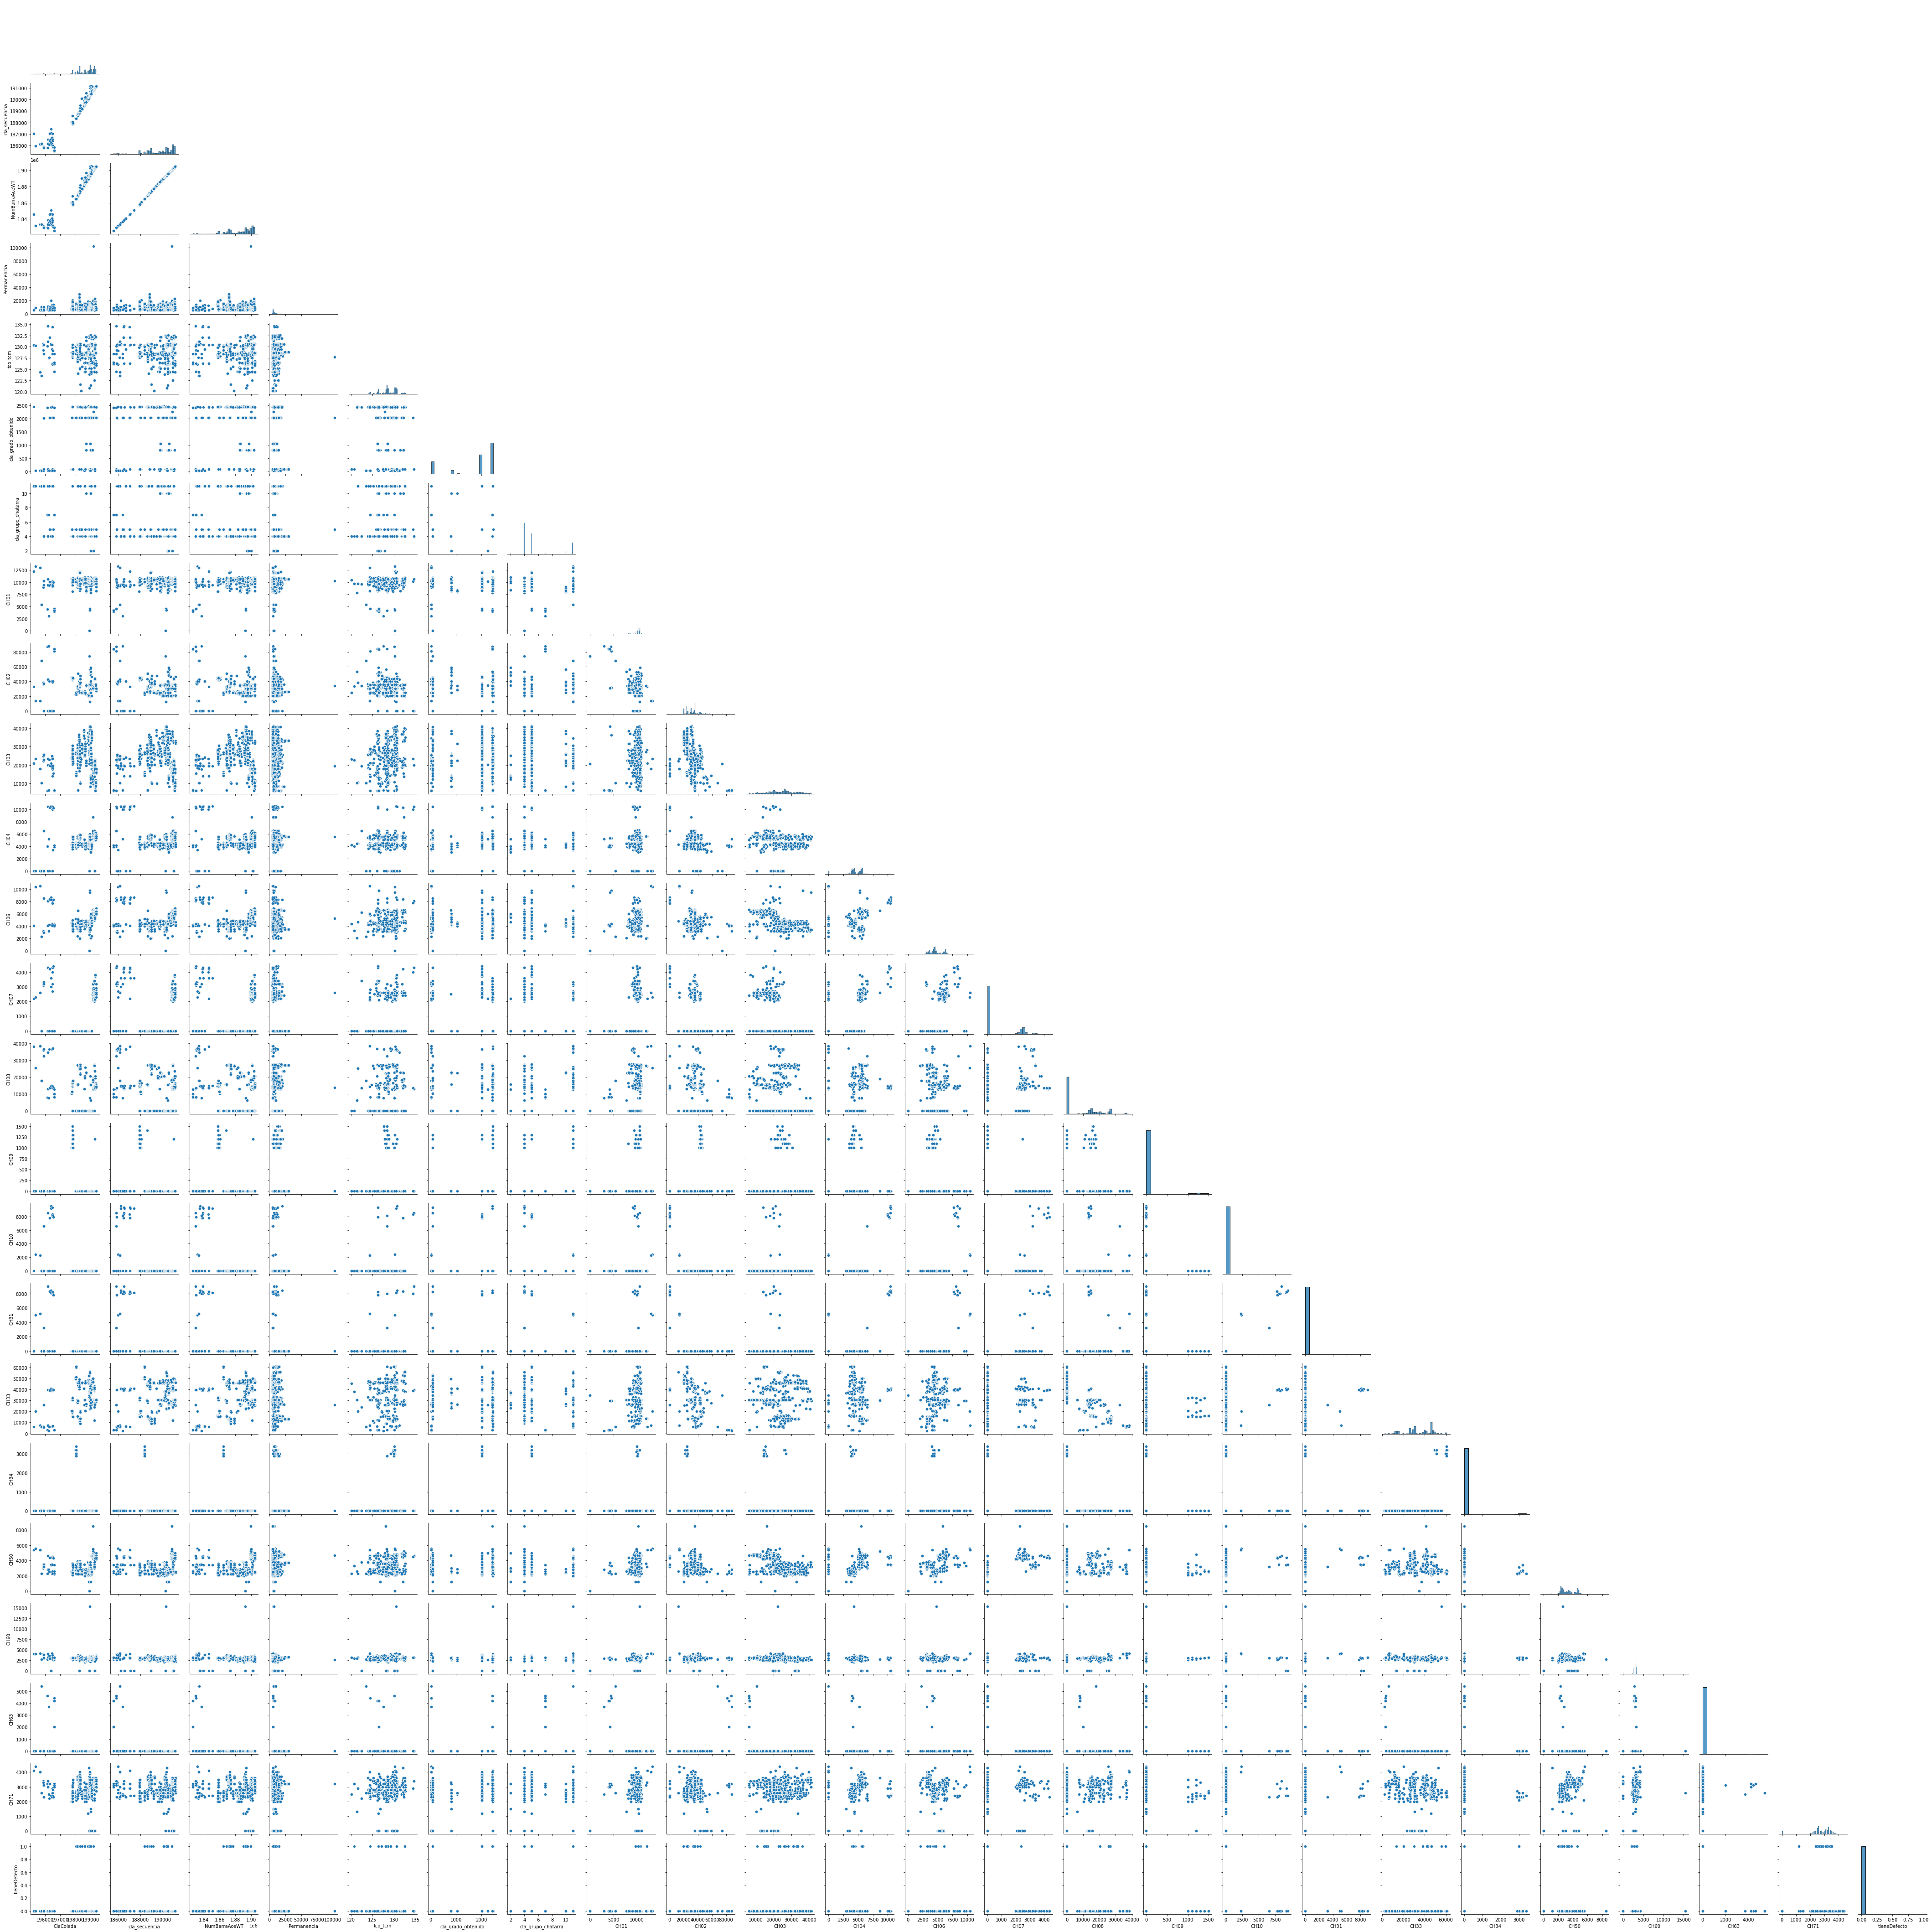

In [57]:
sns.pairplot(df, corner=True);

In [56]:
#definimos nuestro target y las features
y = df["tieneDefecto"]
X = df.drop("tieneDefecto", axis=1)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

## Modelo baseline

In [128]:
pd.Series(y_train).value_counts(normalize=True)

0    0.999023
1    0.000977
Name: tieneDefecto, dtype: float64

In [129]:
accuracy_score(y_train, np.zeros(y_train.size))

0.9990234375

In [130]:
dc = DummyClassifier(strategy='uniform').fit(X_train, y_train)
yhat_dc = dc.predict(X_train)

In [131]:
accuracy_score(y_train, yhat_dc), precision_score(y_train, yhat_dc), recall_score(y_train, yhat_dc)

(0.500390625, 0.0011723329425556857, 0.6)

## Probamos los modelos más comunes

In [132]:
models = [KNeighborsClassifier,LogisticRegression, DecisionTreeClassifier, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier]

In [133]:

accuracies = np.zeros(len(models))
for i, Model in enumerate(models):
    model = Model().fit(X_train, y_train)
    y_hat = model.predict(X_test)
    score = accuracy_score(y_test, y_hat)
    print("Modelo: ", type(model).__name__, " Accuracy: ", score)
    accuracies[i] = score

Modelo:  KNeighborsClassifier  Accuracy:  0.9984139571768438


C:\Users\jeramirez\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Modelo:  LogisticRegression  Accuracy:  0.9984139571768438
Modelo:  DecisionTreeClassifier  Accuracy:  0.9980174464710547
Modelo:  DecisionTreeClassifier  Accuracy:  0.9972244250594766
Modelo:  RandomForestClassifier  Accuracy:  0.9984139571768438
Modelo:  XGBClassifier  Accuracy:  0.9984139571768438


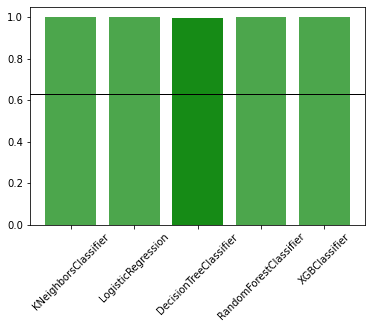

In [134]:
plt.bar([m.__name__ for m in models], accuracies, color='green', alpha=0.7)
plt.axhline(y=0.63, linewidth=1, color='k')
plt.xticks(rotation=45);

In [ ]:
### separación

In [139]:
def gs_best(params, model, model_name):
    model2 = model()
    gs = GridSearchCV(model2, params, cv=5, n_jobs=-1, verbose=1)    
    gs.fit(X_train, y_train)
    best = model(**gs.best_params_).fit(X_train, y_train)
    y_hat=best.predict(X_test)
    r2=r2_score(y_test, y_hat)
    m2 = mean_squared_error(y_test, y_hat)
    #prec = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    return model_name, r2, m2, prec, recall

In [ ]:
models = [KNeighborsRegressor,
          LinearRegression,
          Lasso,
          Ridge,
          ElasticNet,
          DecisionTreeRegressor,
          RandomForestRegressor,
          XGBRegressor]
params = [{'n_neighbors': range(2,50), 'metric': ['manhattan', 'euclidean']},
          {},
          {'alpha': np.logspace(-5, 5)},
          {'alpha': np.logspace(-5, 5)},
          {'alpha': np.logspace(-5, 5)},
          {},
          {},
          {'max_depth':[3,6,10],'learning_rate':[0.01,0.05,0.1],'eta':np.logspace(-1,0,10)}
         ]
names = ["KNeighborsRegressor",
          "LinearRegression",
          "Lasso",
          "Ridge",
          "ElasticNet",
          "DecisionTreeRegressor",
          "RandomForestRegressor",
          "XGBRegressor"]

for model, param, name in zip(models, params, names):
    (model_result, r2_result, m2_result, recall_result) = gs_best(param, model, name)    
    print(name," r2: ",r2_result, " m2: ",m2_result, " recall: ",recall_result)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
